# 层次聚类 Agglomerative Nesting模型

In [1]:
# 定义类Gi和Gj之间的距离为两个簇中心点之间的距离
import numpy as np
def distance(Gi,Gj):
    return np.sum(np.power(np.mean(Gi,axis=0) - np.mean(Gj,axis=0),2))

class AgglomerativeNesting(object):
    def __init__(self,k=3,dist_method = None):
        self.k = k
        self.dist_method = dist_method
        if dist_method is None:
            self.dist_method = distance
        # 记录聚类的中心点
        self.clusterCenter = {}
    
    def fit(self,X):
        m = X.shape[0]
        G = {}
        # 初始化每个簇中只有一个样本，保持每个簇中样本集合是一个二维数组
        for index in range(m):
            G[index] = np.expand_dims(X[index],axis=0)
        M = np.zeros(shape=(m,m))
        
        for i in range(m-1):
            for j in range(i+1,m):
                M[i,j] = self.dist_method(G[i],G[j])
                M[j,i] = M[i,j]
        # 当前的簇数量，每次迭代减少一个簇，直到簇的数量变成k个
        q = m
        while q > self.k:
            # 将距离最小的两个簇合并
            mindis = np.Infinity
            i_ ,j_ = None,None
            for i in range(0,q - 1):
                for j in range(i + 1, q):
                    if M[i,j] < mindis:
                        i_ = i
                        j_ = j
                        mindis = M[i,j]
            # 将Gi和Gj两个集合合并到i中
            G[i_] = np.r_[G[i_],G[j_]]
            for j in range(j_,q-1):
                G[j] = G[j+1]
            # 将第q-1个维度减掉
            del G[q - 1]
            # 从距离矩阵中删除第j_个簇
            # 也就是把第j_行和第j_列都删除
            np.delete(M,j_,axis=1)
            np.delete(M,j_,axis=0)
            
            # 重新计算簇之间的距离
            for j in range(q - 1):
                M[i_,j] = self.dist_method(G[i_],G[j])
                M[j,i_] = M[i_,j]
            
            q = q - 1
        # 迭代完成之后计算每个簇的中心点，用于进行predict
        for idx,clusters in G.items():
            self.clusterCenter[idx] = np.mean(clusters,axis=0)
            
    def predict(self,X):
        ret = []
        rows = X.shape[0]
        for row in range(rows):
            x = X[row]
            mindis = np.Infinity
            class_num = None
            for index,mean_vector in self.clusterCenter.items():
                distance = np.sum(np.power(x - mean_vector,2))
                if distance < mindis:
                    class_num = index
                    mindis = distance
            ret.append(class_num)
            
        return np.asarray(ret)

In [2]:
import utils
from sklearn.datasets.samples_generator import make_blobs
# cluster_std表示每个类别的方差
X, y = make_blobs(n_features=2,n_samples=400, centers=4, cluster_std=0.85, random_state=0)
X = X[:, ::-1]

agnes = AgglomerativeNesting(k=4)
agnes.fit(X)


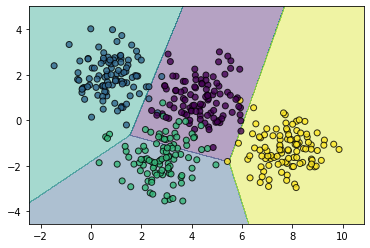

In [ ]:
utils.plot_decision_function(X, y, agnes)
utils.plt.show()

# Kmeans聚类

In [ ]:
class KMeans(object):
    def __init__(self,k=3,epochs=100,tol=1e-3,dist_method=None):
        self.k = k
        self.epochs = epochs
        self.tol = tol
        self.dist_method = dist_method
        if self.dist_method is None:
            # 默认的距离函数是欧氏距离
            self.dist_method = lambda x,y: np.sqrt(np.sum(np.power(x - y , 2)))
        self.cluster_centers_ = {}
    
    def fit(self,X):
        n_sample = X.shape[0]
        # 随机产生k个中心点
        init_centers = np.random.choice(list(range(n_sample)),replace=False,size=self.k)
        for index,center_index in enumerate(init_centers):
            self.cluster_centers_[index] = X[center_index]
        
        for _ in range(self.epochs):
            C = {}
            for index in range(self.k):
                C[index] = []
            for i in range(n_sample):
                best_k = None
                mindis = np.Infinity
                for j in range(self.k):
                    dis = self.dist_method(self.cluster_centers_[j],X[i])
                    if dis < mindis:
                        mindis = dis
                        best_k = j
                C[best_k].append(i)
            
            # 更新中心点
            change = 0.0
            for i in range(self.k):
                new_center = np.mean(X[C[i]],axis=0)
                change = change + self.dist_method(new_center,self.cluster_centers_[i])
                self.cluster_centers_[i] = new_center
            
            # 迭代停止条件    
            if change < self.tol:
                break
        
    def predict(self,X):
        ret = []
        for i in range(X.shape[0]):
            match = None
            mindis = np.Infinity
            for k in range(self.k):
                dis = self.dist_method(self.cluster_centers_[k],X[i])
                if dis < mindis:
                    mindis = dis
                    match = k
            ret.append(match)
        return np.asarray(ret)

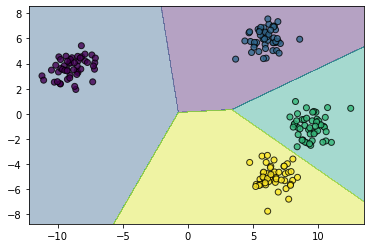

In [ ]:
import utils
from sklearn.datasets.samples_generator import make_blobs
X,y = make_blobs(n_samples=200,n_features=2,centers=4,cluster_std=0.85,random_state=78)
kmeans = KMeans(k=4)
kmeans.fit(X)
utils.plot_decision_function(X,y,kmeans)

# 谱聚类(RatioCut + Normalized Cut (Ncut))

In [ ]:
# 计算矩阵的-1/2次方
D = np.diag(np.array([1,2]))
eig_value,eig_vector = np.linalg.eig(D)
print(eig_vector,eig_vector)
D_1 = eig_vector.T @ np.diag(np.power(eig_value,-0.5)) @ eig_vector
print(D_1)
print('重新合成的D:\n',np.linalg.inv(D_1 @ D_1))
print('原来的矩阵D:\n',D)

[[1. 0.]
 [0. 1.]] [[1. 0.]
 [0. 1.]]
[[1.         0.        ]
 [0.         0.70710678]]
重新合成的D:
 [[1. 0.]
 [0. 2.]]
原来的矩阵D:
 [[1 0]
 [0 2]]


In [ ]:
class SpectralClustering(object):
    # n_cluster:类别数量，
    # n_components:选择的特征向量数量，也就是切分的子图数量
    def __init__(self,n_clusters = 3,n_compoents = 10,gamma = 1):
        self.n_clusters = n_clusters
        self.n_compoents = n_compoents
        self.gamma = gamma
        self.dist_method = lambda x1,x2 : np.exp( - np.sum(np.power(x1 - x2,2)) / (2 * self.gamma * self.gamma))
        
    # 将原来样本的特征进行转化
    def fit_transform(self,X):
        n_samples,n_features =X.shape
        
        # 构建距离矩阵和Laplacian矩阵
        W = np.zeros(shape=(n_samples,n_samples))
        for i in range(n_samples):
            for j in range(i , n_samples):
                w = self.dist_method(X[i],X[j])
                W[i,j] = w
                W[j,i] = w

        D = np.diag(np.sum(W,axis=0))
        L = D - W
        eig_vals,eig_vecs = np.linalg.eig(L)
        # 将特征值进行升序排序，取其中最小的n_components个作为变换矩阵
        sorted_index = np.argsort(eig_vals)
        eig_vecs = eig_vecs[:,sorted_index]
        return eig_vecs[:,:self.n_compoents]
    
    def fit_predict(self,X):
        new_X = self.fit_transform(X)
        # 对新的特征矩阵的行进行标准化
        new_X = new_X / np.sqrt(np.sum(np.power(new_X,2),axis = 1,keepdims=True))
        kmeans = KMeans(k=self.n_clusters)
        kmeans.fit(new_X)
        return kmeans.predict(new_X)


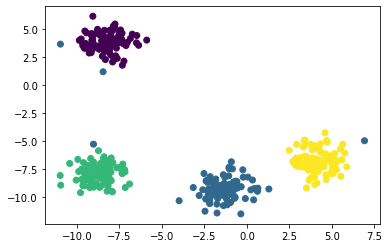

In [ ]:
X,y = make_blobs(n_samples=400,n_features=2,centers=4,cluster_std=0.85)

spectral = SpectralClustering(n_clusters=4)

import  matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c = spectral.fit_predict(X))
plt.show()

In [ ]:
class Ncut(object):
    # n_cluster:类别数量，
    # n_components:选择的特征向量数量，也就是切分的子图数量
    def __init__(self,n_clusters = 3,n_compoents = 10,gamma = 1):
        self.n_clusters = n_clusters
        self.n_compoents = n_compoents
        self.gamma = gamma
        self.dist_method = lambda x1,x2 : np.exp( - np.sum(np.power(x1 - x2,2)) / (2 * self.gamma * self.gamma))
        
    # 将原来样本的特征进行转化
    def fit_transform(self,X):
        n_samples,n_features =X.shape
        
        # 构建距离矩阵和Laplacian矩阵
        W = np.zeros(shape=(n_samples,n_samples))
        for i in range(n_samples):
            for j in range(i , n_samples):
                w = self.dist_method(X[i],X[j])
                W[i,j] = w
                W[j,i] = w

        D = np.diag(np.sum(W,axis=0))
        D1_2 = np.diag(np.power(np.sum(W,axis=0),-1/2))
        L = D - W
        # 对P矩阵进行特征值分解
        P = D1_2 @ L @ D1_2
        eig_vals,eig_vecs = np.linalg.eig(P)
        # 将特征值进行升序排序，取其中最小的n_components个作为变换矩阵
        sorted_index = np.argsort(eig_vals)
        eig_vecs = eig_vecs[:,sorted_index]
        return D1_2 @ eig_vecs[:,:self.n_compoents]
    
    def fit_predict(self,X):
        new_X = self.fit_transform(X)
        # 对新的特征矩阵的行进行标准化
        new_X = new_X / np.sqrt(np.sum(np.power(new_X,2),axis = 1,keepdims=True))
        kmeans = KMeans(k=self.n_clusters)
        kmeans.fit(new_X)
        return kmeans.predict(new_X)


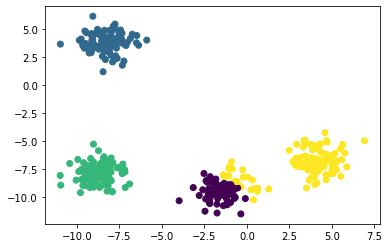

In [ ]:
ncut = Ncut(n_clusters=4)
import  matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c = ncut.fit_predict(X))
plt.show()

# 密度聚类：DBSCAN(Dendity-based spatial Clustering of Application with noise)

In [ ]:
from queue import Queue
import numpy as np
import copy

class DBSCAN(object):
    def __init__(self,eps=0.5,min_sample=3,dist_method=None):
        self.eps = eps
        self.min_sample = min_sample
        self.dist_method = dist_method
        if self.dist_method == None:
            self.dist_method = lambda x1,x2 : np.sqrt(np.sum(np.power(x1 - x2 , 2)))
        self.label = None
    
    def fit(self,X):
        rows = X.shape[0]
        self.label = np.array([-1] * rows)
        M = np.zeros(shape = (rows,rows))
        for i in range(rows - 1):
            for j in range(i , rows):
                M[i,j] = self.dist_method(X[i],X[j])
                M[j,i] = M[i,j]
        # 核心矩阵
        H = set()
        # 找出所有的关键结点
        for i in range(rows):
            if np.sum((M[i,:] <= self.eps).astype('int')) >= self.min_sample:
                H.add(i)
        k = 0
        # 未访问过的节点集合
        # 也就是当前没有确定类别的集合
        W = set(range(rows))
        # 一旦还有关键点就进行搜索并且标记类别
        while len(H) > 0 :
            W_old = copy.deepcopy(W)
            # 宿便找一个关键结点
            o = np.random.choice(list(H))
            W = W - set([o])
            Q = Queue()
            Q.put(o)
            # 一旦队列非空就将这一系列的点归为一个集合
            while not Q.empty():
                q = Q.get()
                # 如果是一个核心点，就将其放入Q中进行可达性搜索
                if q in H :
                    # 找出在目前在W中的关键点，改关键点一定要没有确定类别
                    delta = set(np.argwhere(M[q] <= self.eps).reshape(-1).tolist()) & W
                    for d in delta : 
                        Q.put(d)
                    W = W - delta
            C_k = W_old - W
            k_idx = list(C_k)
            self.label[k_idx] = k
            k = k + 1
            H = H - C_k
    def fit_predict(self,X):
        self.fit(X)
        return self.label

In [ ]:
from  sklearn import datasets
X, _ = datasets.make_moons(n_samples=400,noise=0.04)

In [ ]:
#训练
dbscan = DBSCAN(eps=0.3, min_sample=3)
lable = dbscan.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=lable)
plt.show()